In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
import random

In [15]:
# Load dataset
file_path = 'selected_features_fast.csv'
df = pd.read_csv(file_path)

# Drop first row (feature names)
df = df.iloc[1:].reset_index(drop=True)

# Separate features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels ("Benign", "Early", "Pre", "Pro")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save scaler for later use
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [16]:
print(f"Size of X_train: {X_train.shape}")
print(f"Size of y_train: {y_train.shape}")


Size of X_train: (10418, 146)
Size of y_train: (10418,)


In [17]:
# Define search space for hyperparameters
def generate_random_hyperparams():
    return {
        "learning_rate": random.uniform(0.0001, 0.01),
        "neurons": random.choice([64, 128, 256]),
        "dropout": random.uniform(0.2, 0.5),
        "batch_size": random.choice([32, 64, 128])
    }

In [18]:
# Horse Herd Whale Optimization (HHWO) for hyperparameter tuning
def hhwo_optimize(num_iterations=10, herd_size=5):
    """
    Implements Horse Herd Whale Optimization (HHWO) for hyperparameter tuning.
    - Uses random exploration (horse herd movement).
    - Uses exploitation (whale hunting behavior) to refine solutions.
    """
    best_hyperparams = None
    best_accuracy = 0

    # Initialize herd (randomly generated hyperparameters)
    herd = [generate_random_hyperparams() for _ in range(herd_size)]

    for iteration in range(num_iterations):
        print(f"Iteration {iteration+1}/{num_iterations}")

        # Evaluate each horse (candidate solution)
        for i in range(herd_size):
            params = herd[i]

            # Create FCNN model
            model = Sequential([
                Dense(params["neurons"], activation='relu', input_shape=(X_train.shape[1],)),
                Dropout(params["dropout"]),
                Dense(params["neurons"] // 2, activation='relu'),
                Dropout(params["dropout"] / 2),
                Dense(len(np.unique(y)), activation='softmax')  # Output layer
            ])

            model.compile(optimizer=Adam(learning_rate=params["learning_rate"]),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

            # Train model with early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=10, batch_size=params["batch_size"],
                      validation_split=0.2, callbacks=[early_stopping], verbose=0)

            # Evaluate on test set
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)

            # Update the best solution
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparams = params

        # Exploitation step (whale behavior) - update herd based on the best solution
        for i in range(herd_size):
            herd[i] = {
                "learning_rate": np.clip(best_hyperparams["learning_rate"] + random.uniform(-0.001, 0.001), 0.0001, 0.01),
                "neurons": best_hyperparams["neurons"],
                "dropout": np.clip(best_hyperparams["dropout"] + random.uniform(-0.05, 0.05), 0.2, 0.5),
                "batch_size": best_hyperparams["batch_size"]
            }

    return best_hyperparams

# Run HHWO optimization
best_params = hhwo_optimize(num_iterations=10, herd_size=5)
print("Best Hyperparameters Found:", best_params)

Iteration 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Best Hyperparameters Found: {'learning_rate': 0.001484103987674853, 'neurons': 256, 'dropout': 0.2247858222239084, 'batch_size': 128}


In [19]:
# Train final model using best hyperparameters
final_model = Sequential([
    Dense(best_params["neurons"], activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(best_params["dropout"]),
    Dense(best_params["neurons"] // 2, activation='relu'),
    Dropout(best_params["dropout"] / 2),
    Dense(len(np.unique(y)), activation='softmax')  # Output layer
])

final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
final_model.fit(X_train, y_train, epochs=50, batch_size=best_params["batch_size"],
                validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Save the trained model
final_model.save("leukemia_classifier_hhwo.h5")
print("Model saved as leukemia_classifier_hhwo.h5")

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8386 - loss: 0.4065 - val_accuracy: 0.9747 - val_loss: 0.0782
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9753 - loss: 0.0751 - val_accuracy: 0.9789 - val_loss: 0.0596
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.0493 - val_accuracy: 0.9843 - val_loss: 0.0441
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9880 - loss: 0.0357 - val_accuracy: 0.9846 - val_loss: 0.0399
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9903 - loss: 0.0262 - val_accuracy: 0.9866 - val_loss: 0.0344
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0183 - val_accuracy: 0.9839 - val_loss: 0.0513
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0194 - val_accuracy: 0.9846 - val_loss: 0.0433
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9936 - loss: 0.0174 - val_accuracy: 0.9885 - val_loss

Model saved as leukemia_classifier_hhwo.h5


In [20]:
# Load the saved model
loaded_model = load_model("leukemia_classifier_hhwo.h5")

# Load the scaler
with open("scaler.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

# Load the label encoder
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

# Evaluate on test data
loss, acc = loaded_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {acc * 100:.2f}%")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9888 - loss: 0.0359
Test Accuracy: 99.12%


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

y_pred_probs = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Compute AUC-ROC (One-vs-Rest approach for multi-class)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_test)))
auc_roc = roc_auc_score(y_test_one_hot, y_pred_probs, multi_class='ovr')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9912
Precision: 0.9912
Recall: 0.9912
F1-score: 0.9912
AUC-ROC: 0.9998


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


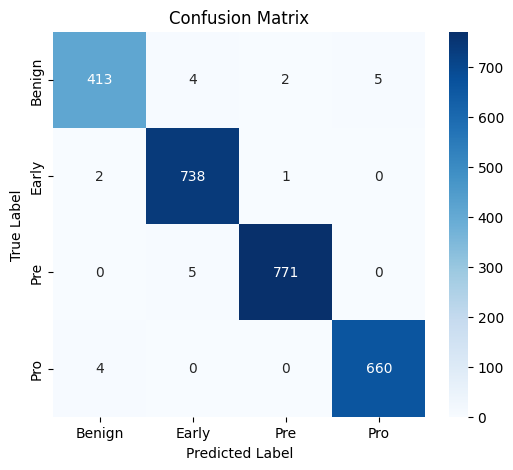

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred_probs = loaded_model.predict(X_test)  # Probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# 1️⃣ **Confusion Matrix**
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=loaded_label_encoder.classes_, yticklabels=loaded_label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define k-fold cross-validation
k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Store results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

# Perform cross-validation
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create model
    model = Sequential([
        Dense(best_params["neurons"], activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(best_params["dropout"]),
        Dense(best_params["neurons"] // 2, activation='relu'),
        Dropout(best_params["dropout"] / 2),
        Dense(len(np.unique(y)), activation='softmax')  # Output layer
    ])

    model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=best_params["batch_size"],
              validation_data=(X_val, y_val), verbose=0)

    # Predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics for this fold
    accuracy_scores.append(accuracy_score(y_val, y_pred_classes))
    precision_scores.append(precision_score(y_val, y_pred_classes, average="weighted"))
    recall_scores.append(recall_score(y_val, y_pred_classes, average="weighted"))
    f1_scores.append(f1_score(y_val, y_pred_classes, average="weighted"))
    auc_scores.append(roc_auc_score(y_val, y_pred, multi_class="ovr"))

# Print averaged results
print(f"Cross-Validation Results (k={k}):")
print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"AUC-ROC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Cross-Validation Results (k=5):
Accuracy: 0.9899 ± 0.0019
Precision: 0.9899 ± 0.0019
Recall: 0.9899 ± 0.0019
F1-score: 0.9899 ± 0.0019
AUC-ROC: 0.9997 ± 0.0001


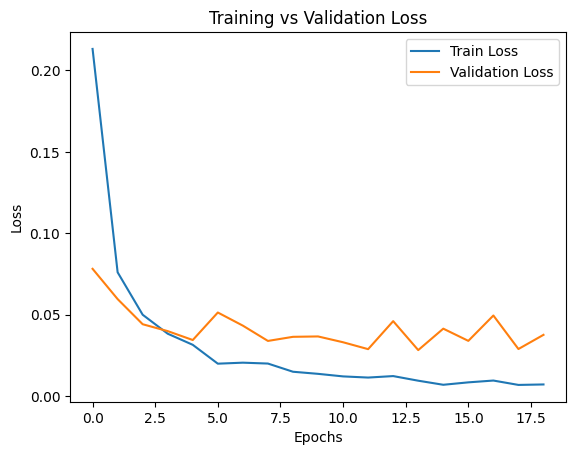

In [27]:
import matplotlib.pyplot as plt

history = final_model.history.history  # Assuming you stored history from model.fit()

plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

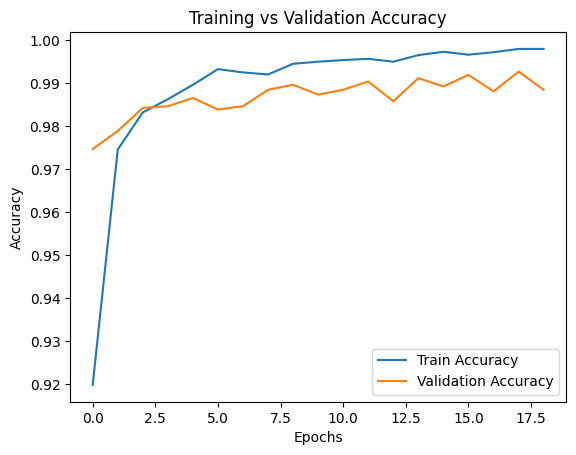

In [28]:
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
import psutil
# Display virtual memory (only limited stats, no access to `total` etc.)
print(f"Available RAM: {psutil.virtual_memory().available / 1e9:.2f} GB")

Available RAM: 8.40 GB
